# Import module

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Descriptors import MolLogP
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import Descriptors
import sys
import multiprocessing
from standardiser import break_bonds, neutralise, rules, unsalt
from standardiser.utils import StandardiseException, sanity_check
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import sys
from tools import tools
from tools import  pipeline as p
from tools import  sar
from sklearn.metrics import cohen_kappa_score
import csv
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import ShuffleSplit
import _pickle as cPickle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit    
import bz2
from glob import glob
import _pickle as cPickle
import pickle
# The next two lines are for optical reasons only. They can be safely disabled.
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18




Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


  * could not import Bokeh, plotting with Highcharts instead.
- no local installation of highcharts found, using web version.
- loading highcharts...


* SA scorer not available. RDKit's Contrib dir needs to be in the Python import path...
tools.tools                                   (211209-10:18)
- no local installation of JSME found, using web version.
* SA scorer not available. RDKit's Contrib dir needs to be in the Python import path...
> interactive IPython session.
tools.sar                                     (211209-10:18)


# Load sdf file

In [2]:

file = "E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/data/test_set_toxic.sdf"

sdfInfo = dict(smilesName='SMILES',molColName='ROMol')
moldf = PandasTools.LoadSDF(file,**sdfInfo)
print(moldf.shape)
#Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
#duplicatas by smiles
moldf = moldf.drop_duplicates(subset=['SMILES'])
#logP
#moldf['logP'] = moldf['Mol'].apply(MolLogP)
#Remove moléculas sem esrtutura no RDKit
moldf = moldf[pd.notnull(moldf['Mol'])]
print(moldf.shape)
#Colunas no pandas
moldf.keys()

Failed to patch pandas - unable to change molecule rendering


(136, 12)
(136, 12)


Index(['id', 'casrn', 'smiles (First)', 'Molecular weight', 'name', 'Outcome',
       'Molecule (RDKit Mol) (InChI Code)', 'reference', 'molecule_form', 'ID',
       'SMILES', 'Mol'],
      dtype='object')

In [3]:
moldf

,id,casrn,smiles (First),Molecular weight,name,Outcome,Molecule (RDKit Mol) (InChI Code),reference,molecule_form,ID,SMILES,Mol
0,660,36635-56-0,,213.2535400390625,-,0,"InChI=1S/C9H11NO3S/c1-8-2-4-9(5-3-8)14(12,13)7...",ECHA,A,,Cc1ccc(S(=O)(=O)CNC=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x000001FB9F7...
1,970,149-30-4,,167.2512969970703,"1,3-benzothiazole-2-thiol",0,InChI=1S/C7H5NS2/c9-7-8-5-3-1-2-4-6(5)10-7/h1-...,ECHA,A,,S=c1[nH]c2ccccc2s1,<rdkit.Chem.rdchem.Mol object at 0x000001FB9F7...
2,239691,15520-10-2,CC(CN)CCCN,116.20464324951172,2-Methylpentanediamine,1,"InChI=1S/C6H16N2/c1-6(5-8)3-2-4-7/h6H,2-5,7-8H...",ToxValDB,not specified,,CC(CN)CCCN,<rdkit.Chem.rdchem.Mol object at 0x000001FB9F7...
3,1148,104-12-1,,153.56576538085938,1-chloro-4-isocyanatobenzene,1,InChI=1S/C7H4ClNO/c8-6-1-3-7(4-2-6)9-5-10/h1-4H,ECHA,V,,O=C=Nc1ccc(Cl)cc1,<rdkit.Chem.rdchem.Mol object at 0x000001FB9F7...
4,256719; 904107; 904108; 904113; 904115,30674-80-7,CC(=C)C(=O)OCCN=C=O,155.15126037597656,2-Isocyanatoethyl methacrylate,1,"InChI=1S/C7H9NO3/c1-6(2)7(10)11-4-3-8-5-9/h1,3...",ToxValDB,not specified,,C=C(C)C(=O)OCCN=C=O,<rdkit.Chem.rdchem.Mol object at 0x000001FB9F7...
...,...,...,...,...,...,...,...,...,...,...,...,...
131,352720; 924323,97-63-2,CCOC(=O)C(C)=C,114.14240264892578,Ethyl methacrylate,0,"InChI=1S/C6H10O2/c1-4-8-6(7)5(2)3/h2,4H2,1,3H3",ToxValDB,not specified,,C=C(C)C(=O)OCC,<rdkit.Chem.rdchem.Mol object at 0x000001FB9F8...
132,205408,109-63-7,[B-]([O+](CC)CC)(F)(F)F,141.9278106689453,(Diethyl ether)trifluoroborane,1,"InChI=1S/C4H10BF3O/c1-3-9(4-2)5(6,7)8/h3-4H2,1...",ToxValDB,not specified,,CC[O+](CC)[B-](F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x000001FB9F8...
133,911342,3748-13-8,CC(=C)c1cccc(c1)C(C)=C,158.23956298828125,"1,3-Diisopropenylbenzene",1,InChI=1S/C12H14/c1-9(2)11-6-5-7-12(8-11)10(3)4...,ToxValDB,not specified,,C=C(C)c1cccc(C(=C)C)c1,<rdkit.Chem.rdchem.Mol object at 0x000001FB9F8...
134,1401,14228-73-0,,256.33795166015625,2-[({4-[(oxiran-2-ylmethoxy)methyl]cyclohexyl}...,0,InChI=1S/C14H24O4/c1-2-12(6-16-8-14-10-18-14)4...,ECHA,A,,C1CC(COCC2CO2)CCC1COCC1CO1,<rdkit.Chem.rdchem.Mol object at 0x000001FB9F8...


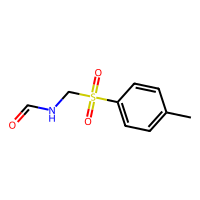

Cc1ccc(S(=O)(=O)CNC=O)cc1


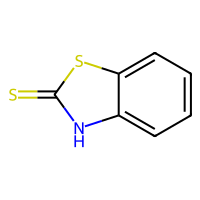

S=c1[nH]c2ccccc2s1


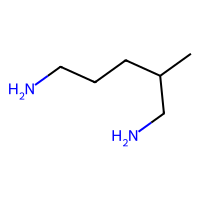

CC(CN)CCCN


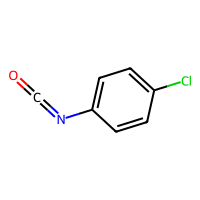

O=C=Nc1ccc(Cl)cc1


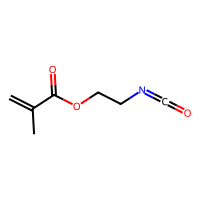

C=C(C)C(=O)OCCN=C=O


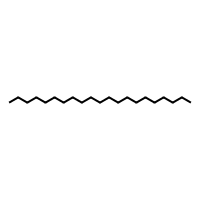

CCCCCCCCCCCCCCCCCCCCC


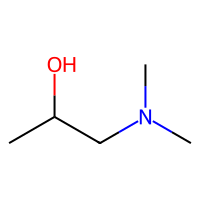

CC(O)CN(C)C


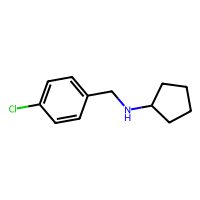

Clc1ccc(CNC2CCCC2)cc1


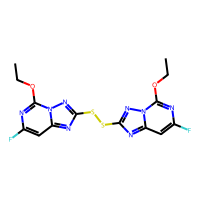

CCOc1nc(F)cc2nc(SSc3nc4cc(F)nc(OCC)n4n3)nn12


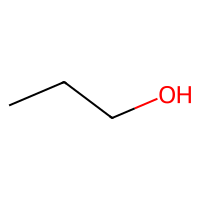

CCCO


In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

def display_molecules_in_column(moldf, num_mols):
    for _, row in moldf.head(num_mols).iterrows():
        smi = row['SMILES']
        if smi is not None:
            mol = Chem.MolFromSmiles(smi)  # Create Mol object from SMILES
            if mol is not None:
                img = Draw.MolToImage(mol, size=(200, 200))
                display(img)
                print(smi)  # Prints the SMILES representation below the image

# Assuming 'df' is your DataFrame
# Display the first 10 molecules, each on a new row
display_molecules_in_column(moldf, 10)


# Data distribution

In [5]:
moldf = moldf.rename(columns={'Label': 'Outcome'})

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


outcomes=(np.unique(moldf['Outcome']))
le.fit(list(set(outcomes)))
y = le.transform( moldf['Outcome'] )



print ("Classes                          : ",(outcomes))
print ("Number of cpds in each class     : ",np.unique([len(y[y==smi]) for smi in y]))
print ("Total number of cpds             : ",len(y))

S = moldf['Outcome']
info = {}
for i,cls in enumerate(S.unique()):
    info.update({cls:i})
    S = S.replace(cls,i)

Classes                          :  ['0' '1']
Number of cpds in each class     :  [60 76]
Total number of cpds             :  136


{'0': 0, '1': 1}

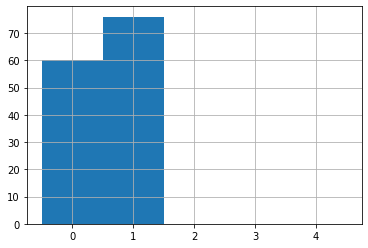

In [7]:
ax = S.hist(bins=np.arange(-0.5,5))
ax.set_xticks(range(0,5))
info

# Load Model

In [9]:
import joblib
rf_morgan = joblib.load('E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Modelo_inhalation_RF_morgan_toxic.pkl')  # Assume these are trained or loaded
rf_maccs = joblib.load('E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Modelo_inhalation_RF_macckeys_toxic.pkl')
rf_modred = joblib.load('E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Modelo_inhalation_RF_modred_toxic.pkl')


# Import Module for Descriptor

In [15]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from mordred import Calculator, descriptors
from fancyimpute import KNN


# Morgan and MACCS keys descriptor

In [10]:
# Morgan fingerprints
nBits = 1024
radius = 2
useFeatures = False
moldf['Morgan_Descriptors'] = moldf['Mol'].apply(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, nBits=nBits, radius=radius, useFeatures=useFeatures))

# MACCS keys
moldf['MACCS_Descriptors'] = moldf['Mol'].apply(lambda mol: MACCSkeys.GenMACCSKeys(mol))



# Modred Calculation

In [11]:
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)
df = calc.pandas(moldf['Mol'])

100%|██████████| 136/136 [00:05<00:00, 25.08it/s]


In [66]:
from fancyimpute import KNN
import pandas as pd
import numpy as np

# Assuming 'df' is your original DataFrame
df_numeric = df.select_dtypes(include=[float])  # Using Python's built-in float type

# Now run fancyimpute KNN, it returns a np.array which I store as a pandas dataframe
# Assuming the columns in df_numeric should be preserved for df_filled
df_filled = pd.DataFrame(KNN(k=3).fit_transform(df_numeric), columns=df_numeric.columns, index=df_numeric.index)


Imputing row 1/11 with 0 missing, elapsed time: 0.001


In [67]:
X = np.array(df_filled)
scaler = StandardScaler()
x=  scaler.fit_transform(X)
#moldf['Modred_Descriptor'] = x.tolist()

In [68]:
print(x.shape)

(11, 564)


In [69]:
import pandas as pd

def reduce_features_by_low_variance(X, num_features_to_keep=739):
    # Ensure X is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)  # Convert to DataFrame assuming X is 2D array-like

    # Calculate variance of each feature
    variances = X.var()
    
    # Sort features by variance (highest to lowest)
    selected_features = variances.sort_values(ascending=False).head(num_features_to_keep).index
    
    # Select columns by selected feature names
    X_reduced = X[selected_features]
    
    return X_reduced

# Usage: Assuming X is a DataFrame or convertable to one
X_reduced = reduce_features_by_low_variance(X, 521)


In [70]:
row_lists = X_reduced.apply(lambda x: x.tolist(), axis=1)


In [71]:
moldf['Modred_Descriptor'] = row_lists

In [45]:
moldf

,id,casrn,smiles (First),Molecular weight,name,Outcome,Molecule (RDKit Mol) (InChI Code),reference,molecule_form,ID,SMILES,Mol,Morgan_Descriptors,MACCS_Descriptors,Mordred_Descriptors,Modred_Descriptors,Modred_Descriptor
0,660,36635-56-0,,213.2535400390625,-,0,"InChI=1S/C9H11NO3S/c1-8-2-4-9(5-3-8)14(12,13)7...",ECHA,A,,Cc1ccc(S(=O)(=O)CNC=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x0000021E27F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.17227603801262906, 0.8886519059101542, 0.93...","[0.17227603801262906, 0.8886519059101542, 0.93...","[4349.509637945195, 8674.913158843581, 4309.82..."
1,970,149-30-4,,167.2512969970703,"1,3-benzothiazole-2-thiol",0,InChI=1S/C7H5NS2/c9-7-8-5-3-1-2-4-6(5)10-7/h1-...,ECHA,A,,S=c1[nH]c2ccccc2s1,<rdkit.Chem.rdchem.Mol object at 0x0000021E315...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.18271594369469454, 0.9650671746798422, 0.6...","[-0.18271594369469454, 0.9650671746798422, 0.6...","[0.0, 3223.993109736407, 466.677662953109, 0.0..."
2,239691,15520-10-2,CC(CN)CCCN,116.20464324951172,2-Methylpentanediamine,1,"InChI=1S/C6H16N2/c1-6(5-8)3-2-4-7/h6H,2-5,7-8H...",ToxValDB,not specified,,CC(CN)CCCN,<rdkit.Chem.rdchem.Mol object at 0x0000021E315...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.5254753991580754, -0.44148053222262684, -0...","[-0.5254753991580754, -0.44148053222262684, -0...","[3379.4116499646852, 9898.293392995274, 5472.1..."
3,1148,104-12-1,,153.56576538085938,1-chloro-4-isocyanatobenzene,1,InChI=1S/C7H4ClNO/c8-6-1-3-7(4-2-6)9-5-10/h1-4H,ECHA,V,,O=C=Nc1ccc(Cl)cc1,<rdkit.Chem.rdchem.Mol object at 0x0000021E315...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.23341754326911535, 0.3606583930911114, 0.3...","[-0.23341754326911535, 0.3606583930911114, 0.3...","[176.5938337215, 2906.485105267678, 669.731285..."
4,256719; 904107; 904108; 904113; 904115,30674-80-7,CC(=C)C(=O)OCCN=C=O,155.15126037597656,2-Isocyanatoethyl methacrylate,1,"InChI=1S/C7H9NO3/c1-6(2)7(10)11-4-3-8-5-9/h1,3...",ToxValDB,not specified,,C=C(C)C(=O)OCCN=C=O,<rdkit.Chem.rdchem.Mol object at 0x0000021E315...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.21471011349678934, -0.05875499955955529, -...","[-0.21471011349678934, -0.05875499955955529, -...","[3429.7654986714906, 5624.892451913993, 3988.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,352720; 924323,97-63-2,CCOC(=O)C(C)=C,114.14240264892578,Ethyl methacrylate,0,"InChI=1S/C6H10O2/c1-4-8-6(7)5(2)3/h2,4H2,1,3H3",ToxValDB,not specified,,C=C(C)C(=O)OCC,<rdkit.Chem.rdchem.Mol object at 0x0000021E316...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.5973710821116887, -0.1212806415544286, -0....","[-0.5973710821116887, -0.1212806415544286, -0....","[2773.7647803637346, 4631.056367748794, 3533.5..."
132,205408,109-63-7,[B-]([O+](CC)CC)(F)(F)F,141.9278106689453,(Diethyl ether)trifluoroborane,1,"InChI=1S/C4H10BF3O/c1-3-9(4-2)5(6,7)8/h3-4H2,1...",ToxValDB,not specified,,CC[O+](CC)[B-](F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x0000021E316...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.5357283255564811, 0.4861326875827931, 0.52...","[-0.5357283255564811, 0.4861326875827931, 0.52...","[0.0, 7094.922514657954, 1664.2588682182409, 0..."
133,911342,3748-13-8,CC(=C)c1cccc(c1)C(C)=C,158.23956298828125,"1,3-Diisopropenylbenzene",1,InChI=1S/C12H14/c1-9(2)11-6-5-7-12(8-11)10(3)4...,ToxValDB,not specified,,C=C(C)c1cccc(C(=C)C)c1,<rdkit.Chem.rdchem.Mol object at 0x0000021E316...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.056679450416644586, 0.68206760188527

# Model Evaluation 

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, classification_report


In [12]:
y_true = moldf['Outcome'].astype(int)  # Ensure it's of integer type, suitable for metrics calculation


In [13]:
# Consensus with probability average 

def predict_with_models_probabilities(moldf):
    # Assuming `predict_proba` method is available and returns probabilities for the positive class
    morgan_probs = rf_morgan.predict_proba(np.array(list(moldf['Morgan_Descriptors'].values)))[:, 1]  # Probabilities for class 1
    maccs_probs = rf_maccs.predict_proba(np.array(list(moldf['MACCS_Descriptors'].values)))[:, 1]  # Probabilities for class 1
    modred_probs = rf_modred.predict_proba(np.array(list(moldf['Modred_Descriptor'].values)))[:, 1]  # Probabilities for class 1

    # Calculate the mean probability across all models
    mean_probs = np.mean([morgan_probs, maccs_probs, modred_probs], axis=0)
   # mean_probs = np.mean([morgan_probs, maccs_probs], axis=0)
  #  mean_probs = np.mean([morgan_probs, modred_probs], axis=0)
    # Convert mean probabilities to final class predictions (e.g., threshold at 0.5)
    final_predictions = (mean_probs > 0.5).astype(int)
    
    return final_predictions

# Run prediction
final_predictions = predict_with_models_probabilities(moldf)
moldf['Predictions'] = final_predictions

print(moldf[['ID', 'SMILES', 'Predictions']])

    ID                                    SMILES  Predictions
0                      Cc1ccc(S(=O)(=O)CNC=O)cc1            1
1                             S=c1[nH]c2ccccc2s1            0
2                                     CC(CN)CCCN            1
3                              O=C=Nc1ccc(Cl)cc1            1
4                            C=C(C)C(=O)OCCN=C=O            1
..  ..                                       ...          ...
131                               C=C(C)C(=O)OCC            1
132                        CC[O+](CC)[B-](F)(F)F            1
133                       C=C(C)c1cccc(C(=C)C)c1            1
134                   C1CC(COCC2CO2)CCC1COCC1CO1            0
135     O=c1n(CC2CO2)c(=O)n(CC2CO2)c(=O)n1CC1CO1            0

[136 rows x 3 columns]


In [126]:
moldf

,name,Outcome,SMILES,ID,Mol,Morgan_Descriptors,MACCS_Descriptors,Predictions
0,3-azidosulfonylbenzoic acid,0,[N-]=[N+]=NS(=O)(=O)c1cccc(C(=O)O)c1,,<rdkit.Chem.rdchem.Mol object at 0x00000248AD7...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,sodium;5-[2-chloro-4-(trifluoromethyl)phenoxy]...,0,O=C([O-])c1cc(Oc2ccc(C(F)(F)F)cc2Cl)ccc1[N+](=...,,<rdkit.Chem.rdchem.Mol object at 0x00000248AD7...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,2-cyclohexyl-6-[(3-cyclohexyl-2-hydroxy-5-meth...,0,Cc1cc(Cc2cc(C)cc(C3CCCCC3)c2O)c(O)c(C2CCCCC2)c1,,<rdkit.Chem.rdchem.Mol object at 0x00000248AD7...,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,4-chloro-1-methylpiperidine;hydrochloride,1,CN1CCC(Cl)CC1.Cl,,<rdkit.Chem.rdchem.Mol object at 0x00000248AD7...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,1-(diaminomethylidene)-2-(2-methylphenyl)guani...,0,Cc1ccccc1N=C(N)N=C(N)N,,<rdkit.Chem.rdchem.Mol object at 0x00000248AD7...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...,...,...,...
729,2-butyloctanoic acid,0,CCCCCCC(CCCC)C(=O)O,,<rdkit.Chem.rdchem.Mol object at 0x00000248AED...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
730,propan-2-olate;titanium(4+),0,CC(C)[O-].CC(C)[O-].CC(C)[O-].CC(C)[O-].[Ti+4],,<rdkit.Chem.rdchem.Mol object at 0x00000248AED...,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
731,dichloro(phenyl)arsane,1,Cl[As](Cl)c1ccccc1,,<rdkit.Chem.rdchem.Mol object at 0x00000248AED...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
732,"1,1-dichloroprop-1-ene",0,CC=C(Cl)Cl,,<rdkit.Chem.rdchem.Mol object at 0x00000248AED...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


# Metrics performance

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score

# Assuming y_true and final_predictions are defined
conf_matrix = confusion_matrix(y_true, final_predictions)
print("Confusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_true, final_predictions)
print("Accuracy:", accuracy)

# Assuming you have probabilities (modify if you only have labels)
# For labels only:
auc_score = roc_auc_score(y_true, final_predictions)
print("AUC Score:", auc_score)

f1 = f1_score(y_true, final_predictions, average='binary')  # For binary classification
print("F1 Score:", f1)

tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Correct Classification Rate (CCR)
ccr = (sensitivity + specificity) / 2
print("CCR (Correct Classification Rate):", ccr)

# Positive Predictive Value (PPV)
ppv = tp / (tp + fp)
print("PPV (Positive Predictive Value):", ppv)

# Negative Predictive Value (NPV)
npv = tn / (tn + fn)
print("NPV (Negative Predictive Value):", npv)


Confusion Matrix:
[[45 15]
 [20 56]]
Accuracy: 0.7426470588235294
AUC Score: 0.743421052631579
F1 Score: 0.7619047619047618
Sensitivity: 0.7368421052631579
Specificity: 0.75
CCR (Correct Classification Rate): 0.743421052631579
PPV (Positive Predictive Value): 0.7887323943661971
NPV (Negative Predictive Value): 0.6923076923076923
